# Expected structure of folder:

```
ada-2024-project-outliars/
    ├── results.ipynb
    └── data/
        ├── paths-and-graph
            ├── articles.tsv
            ├── categories.tsv
            ├── links.tsv
            ├── paths_finished.tsv
            ├── paths_unfinished.tsv
            ├── shortest-path-distance-matrix.txt
        ├── plaintext_articles/
            └── ...
        └── articles_html
            └── css
            ├── images
            ├── js
            ├── wp
            ├── index.htm
```

# Loading the data

In [884]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from urllib.parse import unquote
import seaborn as sns
import math 
import scipy.stats as stats

## Loading article names

In [885]:
articles_df = pd.read_csv("data/paths-and-graph/articles.tsv", sep = "\t", comment = '#', header = None)
articles_df.columns = ['article_name']

# Decode names
articles_df['article_name'] = articles_df['article_name'].apply(unquote) 

print(articles_df.shape)
articles_df.head()

(4604, 1)


,article_name
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


## Loading categories for each article

In [886]:
categories_df = pd.read_csv("data/paths-and-graph/categories.tsv", sep = "\t", comment = '#', header = None)
categories_df.columns = ['article_name', 'category']

categories_df.head()

,article_name,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [887]:
# Decode article names
categories_df['article_name'] = categories_df['article_name'].apply(unquote)

# Split the 'category' column into multiple columns (one for each level of category)
df_split = categories_df['category'].str.split('.', expand=True).drop(columns=[0])

# Rename the columns to represent each level
df_split.columns = ['Level_1', 'Level_2', 'Level_3']

# Join the new columns with starting dataframe
categories_df = categories_df.drop(columns = ['category']).join(df_split)

print(categories_df.shape)
categories_df.head()

(5204, 4)


,article_name,Level_1,Level_2,Level_3
0,Áedán_mac_Gabráin,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,People,Historical_figures,None
2,Åland,Countries,None,None
3,Åland,Geography,European_Geography,European_Countries
4,Édouard_Manet,People,Artists,None


## Loading existing links between articles

In [888]:
links_df = pd.read_csv("data/paths-and-graph/links.tsv", sep = "\t", comment = '#', header = None)
links_df.columns = ['source', 'target']

# Decode article names
links_df = links_df.map(unquote)

print(links_df.shape)
links_df.head()

(119882, 2)


,source,target
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [889]:
# Initialize adjacency matrix, 1 if corresponding article has an outgoing link to column article
articles = articles_df['article_name'].tolist()
adj_matrix = pd.DataFrame(0, index=articles, columns=articles)

# Add existing links
for _, row in links_df.iterrows():
    source, target = row['source'], row['target']
    adj_matrix.loc[source, target] = 1

print(adj_matrix.shape)
adj_matrix.head()

(4604, 4604)


,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Åland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Édouard_Manet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Éire,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Óengus_I_of_the_Picts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Loading data about finished paths

In [890]:
finished_df = pd.read_csv("data/paths-and-graph/paths_finished.tsv", sep = "\t", comment = '#', header = None)
finished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'difficulty_rating']

print(finished_df.shape)
finished_df.head()

(51318, 5)


,hashIP,timestamp,duration,path,difficulty_rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [891]:
finished_df = pd.read_csv("data/paths-and-graph/paths_finished.tsv", sep = "\t", comment = '#', header = None)
finished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'difficulty_rating']

# Decode article names and transform path into list
finished_df['path'] = finished_df['path'].apply(lambda a: [unquote(art) for art in a.split(";")])

# Calculate path length
finished_df['path_length'] = finished_df['path'].apply(len)

# Calculate number of backward clicks in each path
finished_df['num_backward'] = finished_df['path'].apply(lambda a: a.count("<"))

# Convert timestamp to reasonable units 
finished_df['timestamp'] = pd.to_datetime(finished_df['timestamp'], unit='s')

finished_df.head()

,hashIP,timestamp,duration,path,difficulty_rating,path_length,num_backward
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,9,0
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,5,0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,8,0
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,4,0
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,7,0


## Loading data about unfinished paths

In [892]:
unfinished_df = pd.read_csv("data/paths-and-graph/paths_unfinished.tsv", sep = "\t", comment = '#', header = None)
unfinished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'target_article', 'type_end']

# Decode article names and transform path to list
unfinished_df['path'] = unfinished_df['path'].apply(lambda a: [unquote(art) for art in a.split(";")])

# Decode article names and transform path to list
unfinished_df['target_article'] = unfinished_df['target_article'].apply(lambda a: unquote(a))

# Calculate length of unfinished paths
unfinished_df['path_length'] = unfinished_df['path'].apply(len)

# Calculate number of backward clicks
unfinished_df['num_backward'] = unfinished_df['path'].apply(lambda a: a.count("<"))

# Convert timestampt to reasonable units 
unfinished_df['timestamp'] = pd.to_datetime(unfinished_df['timestamp'], unit='s')

unfinished_df.head()

,hashIP,timestamp,duration,path,target_article,type_end,path_length,num_backward
0,2426091a53125110,2011-02-07 05:02:15,1804,[Obi-Wan_Kenobi],Microsoft,timeout,1,0
1,26141fd878806294,2011-02-07 05:14:11,1805,[Julius_Caesar],Caracas,timeout,1,0
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,3,0
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,[Paraguay],Mount_St._Helens,restart,1,0
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,2,0


## Loading data about shortest paths between articles (Floyd-Warshall algorithm)

In [893]:
# Open text file with distances
with open('data/paths-and-graph/shortest-path-distance-matrix.txt', 'r') as file:
    lines = file.readlines()

# Skip metadata lines
lines = lines[17:]

# Transform each line into a list of distances
distances = []
for line in lines:
    # Treat each character as a distance
    distances.append([np.nan if char == '_' else int(char) for char in line.strip()])

# Retrieve list of article names
article_names = articles_df['article_name'].tolist()
article_names = [unquote(x) for x in article_names] 

# Ensure the number of articles in articles_df matches the number of distances
assert len(article_names) == len(distances)

# Create the distance matrix dataframe
distance_df = pd.DataFrame(distances, columns=article_names, index=article_names)

distance_df.head()

,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0
Åland,NaN,0.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0
Édouard_Manet,NaN,NaN,0.0,NaN,NaN,NaN,3.0,3.0,2.0,2.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0
Éire,NaN,NaN,NaN,0.0,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
Óengus_I_of_the_Picts,NaN,NaN,NaN,NaN,0.0,NaN,2.0,2.0,3.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0


# Analysing the data

## Categories statistics

In [894]:
len(articles_df) # number of articles

4604

In [895]:
# group by article to see statistics of each category and its levels
article_categories = categories_df.groupby('article_name')[['Level_1', 'Level_2', 'Level_3']] 
print(article_categories.count().head()) # categories of each article

              Level_1  Level_2  Level_3
article_name                           
10th_century        1        1        0
11th_century        1        1        0
12th_century        1        1        0
13th_century        1        1        0
14th_century        1        1        0


In [896]:
len(article_categories)

4598

Some articles do not appear in the categories dataframe.

In [897]:
articles_with_cats = list(article_categories.groups.keys()) # get articles that appear in category_df
for name in articles_df.article_name.values: # find articles that do not appear in category_df
    if name not in articles_with_cats:
        print(name)

Directdebit
Donation
Friend_Directdebit
Pikachu
Sponsorship_Directdebit
Wowpurchase


The category of these articles is unknown.

In [898]:
# overview of categories of each article
# create new dataframe where each row is one article with information about its categories
articles = articles_df['article_name'].tolist()
article_category_data = pd.DataFrame(list(), index=articles, columns=['Level_1_cats', 'Level_2_cats', 'Level_3_cats', 'total_def_cats'])

for group, vals in article_categories:
    article_category_data.loc[group, 'Level_1_cats'] = (vals['Level_1'].tolist())
    article_category_data.loc[group, 'Level_2_cats'] = (vals['Level_2'].tolist())
    article_category_data.loc[group, 'Level_3_cats'] = (vals['Level_3'].tolist())
    article_category_data.loc[group, 'total_def_cats'] = vals.shape[0]

In [899]:
article_category_data.head()

,Level_1_cats,Level_2_cats,Level_3_cats,total_def_cats
Áedán_mac_Gabráin,"[History, People]","[British_History, Historical_figures]",[British_History_1500_and_before_including_Rom...,2
Åland,"[Countries, Geography]","[None, European_Geography]","[None, European_Countries]",2
Édouard_Manet,[People],[Artists],[None],1
Éire,"[Countries, Geography]","[None, European_Geography]","[None, European_Countries]",2
Óengus_I_of_the_Picts,"[History, People]","[British_History, Historical_figures]",[British_History_1500_and_before_including_Rom...,2


In [900]:
article_category_data.groupby('total_def_cats')['Level_1_cats'].count() # see number of categories per article distribution

total_def_cats
1    4000
2     590
3       8
Name: Level_1_cats, dtype: int64

In [901]:
# for each category level, print percentage of NaN values
print("Level_1 :", 100*(categories_df.shape[0] - categories_df.Level_1.count())/categories_df.shape[0],"%")
print("Level_2 :",100*(categories_df.shape[0] - categories_df.Level_2.count())/categories_df.shape[0], "%")
print("Level_3 :", 100*(categories_df.shape[0] - categories_df.Level_3.count())/categories_df.shape[0], "%")

Level_1 : 0.0 %
Level_2 : 5.265180630284396 %
Level_3 : 71.52190622598002 %


A defined category of an article is composed of 3 levels, where level 1 is the most general category, level 2 is a subcategory of level 1, and level 3 is a subcategory of level 2. A defined category cannot have a value of level 2 without having a value of level 1, and the same goes with level 3 and level 2. A defined category must at least have a value in the level 1.

Each article can have multiple defined categories, or none. The total number of articles in the dataset is **4604**. Six articles do not have any defined category. 4000 articles have one defined category, 590 have two defined categories, and 8 have three defined categories.

For all existing defined categories of all articles, the level 1 value is always present. Level 2 value is missing in 5.26% of cases, while level 3 is missing in 71.52% of cases.

In [902]:
print("Number of unique categories for each category level")
print("Level_1: ", len(categories_df.Level_1.unique()))
print("Level_2: ", len(categories_df.Level_2.unique()))
print("Level_3: ", len(categories_df.Level_3.unique()))

print(f"Unique Level 1 categories\n {categories_df.Level_1.unique()}\n")
print(f"First 20 unique Level 2 categories\n {categories_df.Level_2.unique()[0:20]}\n")
print(f"Unique Level 3 categories\n {categories_df.Level_3.unique()}")

Number of unique categories for each category level
Level_1:  15
Level_2:  102
Level_3:  28
Unique Level 1 categories
 ['History' 'People' 'Countries' 'Geography' 'Business_Studies' 'Science'
 'Everyday_life' 'Design_and_Technology' 'Music' 'IT'
 'Language_and_literature' 'Mathematics' 'Religion' 'Art' 'Citizenship']

First 20 unique Level 2 categories
 ['British_History' 'Historical_figures' None 'European_Geography'
 'Artists' 'Currency' 'General_history' 'Military_History_and_War'
 'Physics' 'Sports_events' 'Storms' 'Recent_History'
 'Geology_and_geophysics' 'Natural_Disasters' 'Railway_transport'
 'Sports_and_games_people' 'Biology' 'Performers_and_composers'
 'Computing_hardware_and_infrastructure' 'Companies']

Unique Level 3 categories
 ['British_History_1500_and_before_including_Roman_Britain' None
 'European_Countries' 'Space_Astronomy' 'Health_and_medicine'
 'General_Physics' 'Mammals' 'Plants' 'British_History_15001750'
 'Asian_Countries' 'Middle_Eastern_Countries' 'Chemical

We have 15 possible values for level 1 categories, 102 for level 2 categories and 28 for level 3 categories.

In [903]:
# overview of existing categories
pd.set_option('display.max_rows', None)

# Number of articles belonging to a Level 1 category, and for each level 1 value % of articles that have non null value of corresponding Level_2 category
level_1_counts = pd.DataFrame(categories_df.groupby('Level_1').size())
level_1_counts.columns = ['totalEntries']
level_1_counts['percNonNullLevel2'] = 100 * categories_df.groupby('Level_1')['Level_2'].count() / level_1_counts.totalEntries

print(level_1_counts.head())

# Number of articles belonging to a Level 2 category, and for each level 2 value % of articles that have non null value of corresponding Level_3 category
level_2_counts = pd.DataFrame(categories_df.groupby(['Level_1', 'Level_2']).size())
level_2_counts.columns = ['totalEntries']
level_2_counts['percNonNullLevel3'] = 100 * categories_df.groupby(['Level_1', 'Level_2'])['Level_3'].count() / level_2_counts.totalEntries

print(level_2_counts.head())

# Number of articles belonging to a Level 3 category
level_3_counts = categories_df.groupby(['Level_1', 'Level_2', 'Level_3']).size()
print(level_3_counts.head())

                       totalEntries  percNonNullLevel2
Level_1                                               
Art                              38              100.0
Business_Studies                 88              100.0
Citizenship                     224              100.0
Countries                       229                0.0
Design_and_Technology           254              100.0
                            totalEntries  percNonNullLevel3
Level_1          Level_2                                   
Art              Art                  36                0.0
                 Artists               2                0.0
Business_Studies Business             28                0.0
                 Companies            18                0.0
                 Currency             14                0.0
Level_1    Level_2                               Level_3                             
Geography  African_Geography                     African_Countries                       57
           Centra

For *Level_1* categories, we observe that for each individual category, all articles of this category either all have a corresponding *Level_2* category value specified, or they all don't. This is not the case when observing *Level_2* categories, where for some of them (f.e. *African_Geography*) articles of this category may or may not have a corresponding *Level_3* category specified.  

Specifically, when looking at *Level_1* categories, all the articles in the categories *Countries* and *Mathematics* do not have corresponding *Level_2* subcategories specified. For the *Science* category (*Level_1*), all articles have both corresponding *Level_2* subcategory and *Level_3* subcategory specified. In the *History* category (*Level_1*), only some articles of the subcategory *British_History* (*Level_2*) have specified values for corresponding *Level_3* categories. This is also the case for the *Level_2* categories *African_Geography, Central_and_South_American_Geography, European_Geography, Geography_of_Asia, Geography_of_the_Middle_East* that are subcategories of the *Level_1 Geography* category. For all articles that have other values of the *Level_2* category, there are no corresponding *Level_3* subcategories specified.

## Analysing links

### Outgoing links

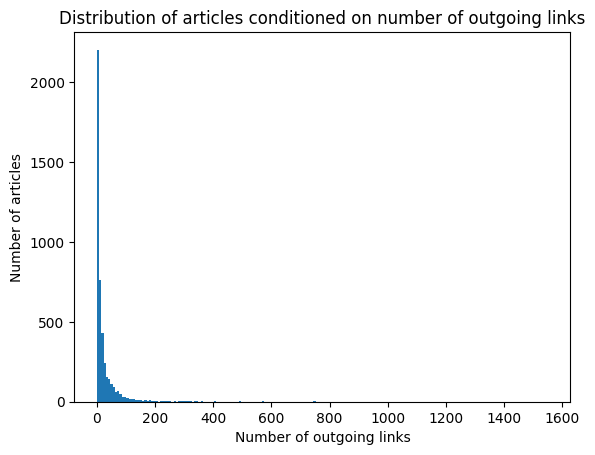

In [904]:
# see how many outgoing links each article has
outgoing_links = adj_matrix.apply(lambda a: a.sum(), axis = 0) # distribution of number of outgoing links per article
bins_300 = plt.hist(outgoing_links, bins = 200)
plt.xlabel("Number of outgoing links")
plt.ylabel("Number of articles")
plt.title("Distribution of articles conditioned on number of outgoing links")
plt.show()

In [905]:
outgoing_links.describe()

count    4604.000000
mean       26.038662
std        62.746827
min         0.000000
25%         2.000000
50%         8.000000
75%        25.000000
max      1551.000000
dtype: float64

In [906]:
(outgoing_links > 100).sum()

223

In [907]:
outgoing_links.value_counts().sort_index().head()

0    469
1    442
2    308
3    281
4    200
Name: count, dtype: int64

The dataset containts 469 articles that have 0 outgoing links. There is one article (outlier) that contains 1551 outgoing links.
The median of the number of outgoing links is 8.

We can see the distribution of number of outgoing links is skewed.

count    4135.000000
mean        2.342098
std         1.426441
min         0.000000
25%         1.386294
50%         2.302585
75%         3.367296
max         7.346655
dtype: float64


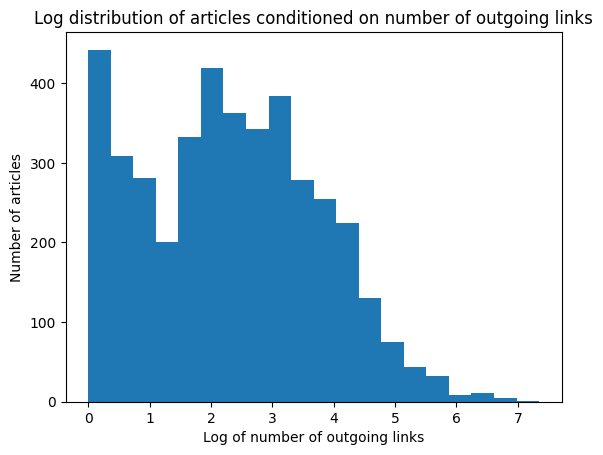

In [908]:
outgoing_links = adj_matrix.apply(lambda a: np.log(a.sum()) if a.sum() > 0 else None, axis = 0)
outgoing_links.dropna(inplace=True)
print(outgoing_links.describe())
plt.hist(outgoing_links, bins = 20)
plt.xlabel("Log of number of outgoing links")
plt.ylabel("Number of articles")
plt.title("Log distribution of articles conditioned on number of outgoing links")
plt.show()

### Ingoing links

In [909]:
ingoing_links = adj_matrix.apply(lambda a: a.sum(), axis = 1)
ingoing_links.describe()

count    4604.000000
mean       26.038662
std        24.201491
min         0.000000
25%        11.000000
50%        19.000000
75%        33.000000
max       294.000000
dtype: float64

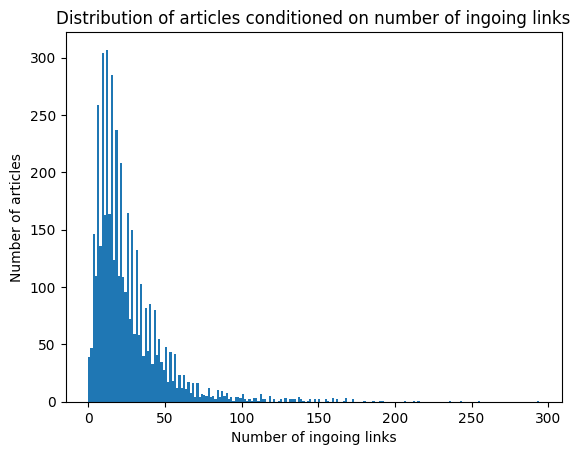

In [910]:
# see how many ingoing links each article has
plt.hist(ingoing_links, bins = 200)
plt.xlabel("Number of ingoing links")
plt.ylabel("Number of articles")
plt.title("Distribution of articles conditioned on number of ingoing links")
plt.show()

In [911]:
ingoing_links.value_counts().sort_index().head()

0    17
1    22
2    47
3    60
4    86
Name: count, dtype: int64

In [912]:
(ingoing_links > 100).sum()

87

The dataset contains 17 articles with 0 ingoing links.

223 articles have more than 100 outgoing links, while only 87 have more than 100 ingoing links.

## Analysing shortest paths

In [913]:
distance_df.head()

,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0
Åland,NaN,0.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0
Édouard_Manet,NaN,NaN,0.0,NaN,NaN,NaN,3.0,3.0,2.0,2.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0
Éire,NaN,NaN,NaN,0.0,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
Óengus_I_of_the_Picts,NaN,NaN,NaN,NaN,0.0,NaN,2.0,2.0,3.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0


In [914]:
shortest_paths = distance_df.apply(lambda r: r.tolist(), axis = 1) # to each article, assign it a list of shortest path distances from other articles
shortest_paths.head()

Áedán_mac_Gabráin        [0.0, nan, nan, nan, nan, nan, 3.0, 3.0, 3.0, ...
Åland                    [nan, 0.0, nan, nan, nan, nan, 2.0, 2.0, 2.0, ...
Édouard_Manet            [nan, nan, 0.0, nan, nan, nan, 3.0, 3.0, 2.0, ...
Éire                     [nan, nan, nan, 0.0, nan, nan, 3.0, 3.0, 3.0, ...
Óengus_I_of_the_Picts    [nan, nan, nan, nan, 0.0, nan, 2.0, 2.0, 3.0, ...
dtype: object

In [915]:
num_nans = shortest_paths.apply(lambda a: sum(math.isnan(x) for x in a))
num_nans.describe()

count    4604.000000
mean      565.590139
std       259.920657
min       543.000000
25%       549.000000
50%       549.000000
75%       549.000000
max      4603.000000
dtype: float64

In [916]:
sum(num_nans.values)

2603977

In [917]:
print(f"{sum(num_nans.values)*100 / (articles_df.shape[0]**2)}% of possible missions defined by source and target article are unwinnable")

12.284755408548152% of possible missions defined by source and target article are unwinnable


There are 2603977 source-goal defined missions from all 21196816 (4604 * 4604) possible that are not winnable since there exist no shortest path from source to goal. They represent 12.28% of possible missions.

## Analysing finished paths

In [918]:
finished_df.head()

,hashIP,timestamp,duration,path,difficulty_rating,path_length,num_backward
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,9,0
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,5,0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,8,0
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,4,0
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,7,0


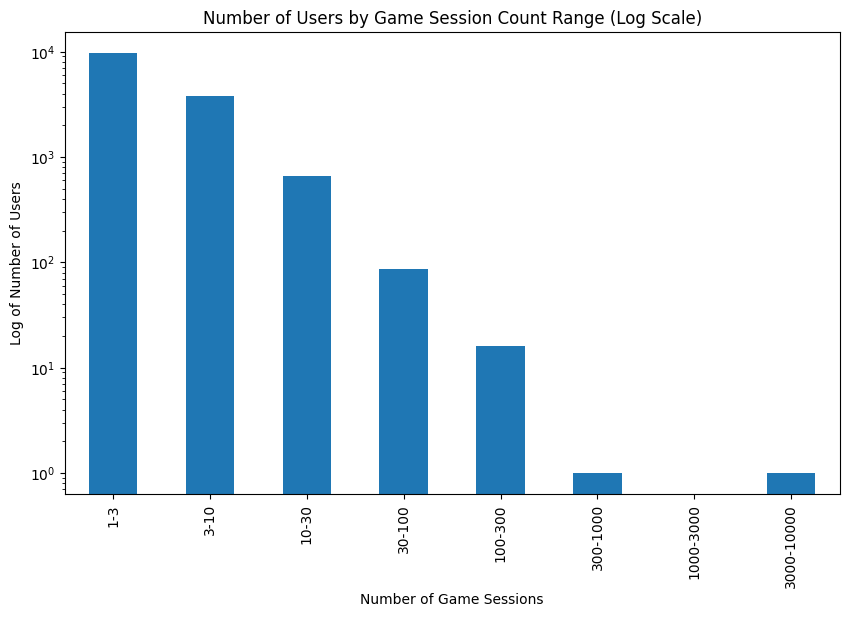

In [919]:
# Count the occurrences of each IP hash
ip_counts = finished_df['hashIP'].value_counts()

bins = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000]
labels = ["1-3", "3-10", "10-30", "30-100", "100-300", "300-1000", "1000-3000", "3000-10000"]

# Cut the IP counts into the specified bins
ip_count_bins = pd.cut(ip_counts, bins=bins, labels=labels, right=False)

# Count the number of users (IPs) in each bin
user_count_per_bin = ip_count_bins.value_counts().sort_index()

# Plot the distribution of users per play frequency bin with log scale
plt.figure(figsize=(10, 6))
user_count_per_bin.plot(kind='bar', logy=True)
plt.title("Number of Users by Game Session Count Range (Log Scale)")
plt.xlabel("Number of Game Sessions")
plt.ylabel("Log of Number of Users")
plt.show()

### Path length

In [920]:
finished_df.path_length.describe()

count    51318.000000
mean         6.757434
std          4.680718
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64

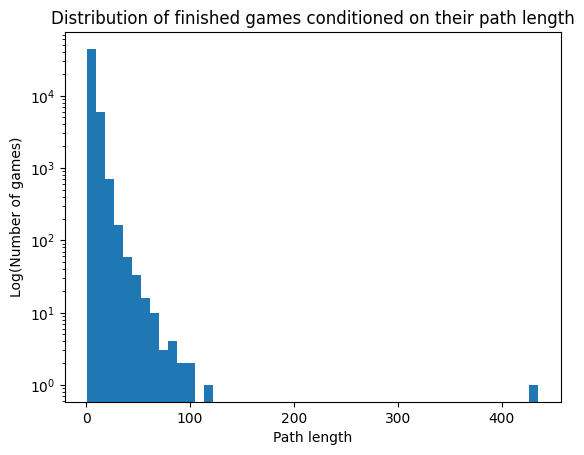

In [921]:
path_bin_50 = plt.hist(finished_df.path_length, log=True, bins=50)
plt.xlabel("Path length")
plt.ylabel("Log(Number of games)")
plt.title("Distribution of finished games conditioned on their path length")
plt.show()

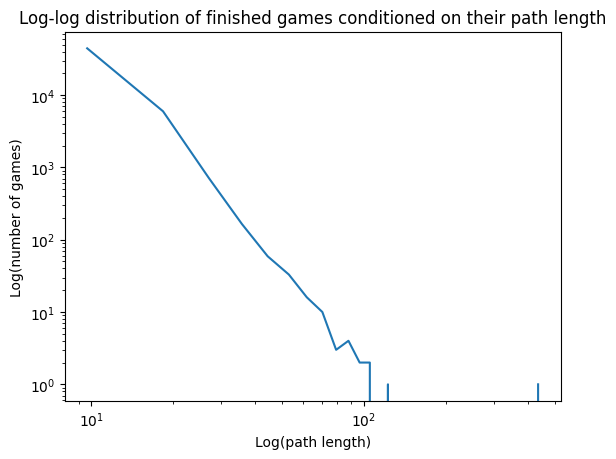

In [922]:
plt.loglog(path_bin_50[1][1:], path_bin_50[0])
plt.xlabel("Log(path length)")
plt.ylabel("Log(number of games)")
plt.title("Log-log distribution of finished games conditioned on their path length")
plt.show()

In [923]:
finished_df.path_length.value_counts().sort_index().head(20)

path_length
1        11
2       798
3      3424
4      8558
5     10941
6      8137
7      5868
8      3954
9      2650
10     1713
11     1256
12      867
13      623
14      462
15      359
16      275
17      232
18      183
19      151
20      119
Name: count, dtype: int64

We can see there are outliers, since the max is 435 and the mean is 6.75. We can also see the distribution is skewed.

### Backward option

In [924]:
finished_df.num_backward.describe()

count    51318.000000
mean         0.400659
std          1.451216
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         45.000000
Name: num_backward, dtype: float64

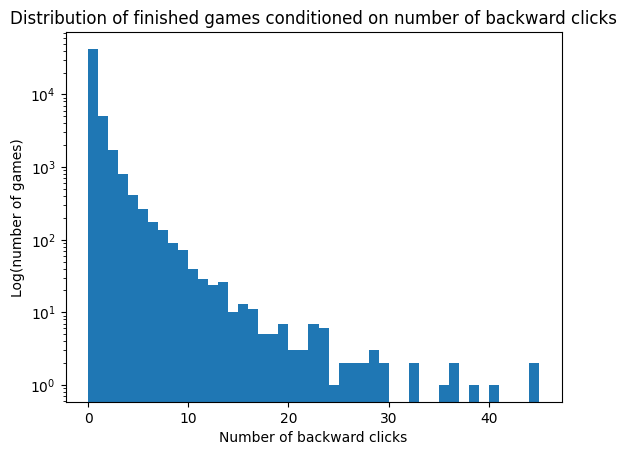

In [925]:
backward_45_bins = plt.hist(finished_df.num_backward, log=True, bins=45)
plt.xlabel("Number of backward clicks")
plt.ylabel("Log(number of games)")
plt.title("Distribution of finished games conditioned on number of backward clicks")
plt.show()

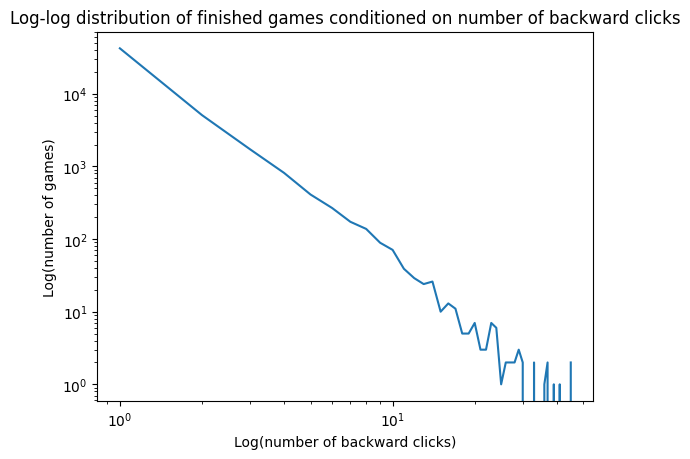

In [926]:
plt.loglog(backward_45_bins[1][1:], backward_45_bins[0])
plt.xlabel("Log(number of backward clicks)")
plt.ylabel("Log(number of games)")
plt.title("Log-log distribution of finished games conditioned on number of backward clicks")
plt.show()

In [927]:
finished_df.num_backward.value_counts().sort_index().head(20)

num_backward
0     42323
1      5095
2      1726
3       815
4       411
5       268
6       173
7       138
8        89
9        71
10       39
11       29
12       24
13       26
14       10
15       13
16       11
17        5
18        5
19        7
Name: count, dtype: int64

In [928]:
print("The backward option was not used at all in ", 100*finished_df.num_backward.value_counts().sort_index().iloc[0] / finished_df.shape[0] , " % of missions")

The backward option was not used at all in  82.4720371019915  % of missions


In most finished missions, the backward option was not used at all. The distribution of backward uses per mission is therefore also skewed. It resembles a proper power law distribution

### Duration

In [929]:
finished_df.duration.describe()

count    51318.000000
mean       158.276199
std        360.841904
min          0.000000
25%         60.000000
50%        107.000000
75%        183.000000
max      35091.000000
Name: duration, dtype: float64

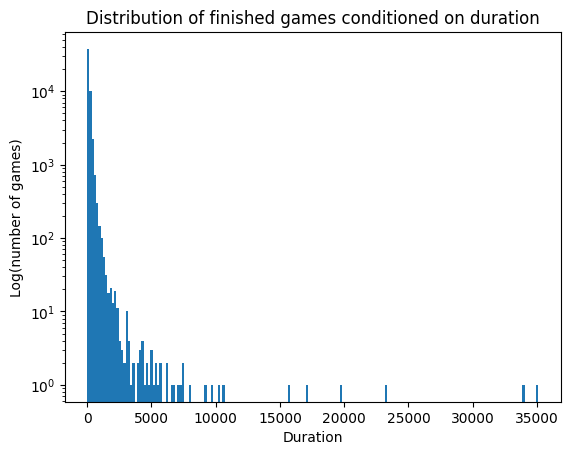

In [930]:
bins_200 = plt.hist(finished_df.duration, bins = 200, log=True)
plt.xlabel("Duration")
plt.ylabel("Log(number of games)")
plt.title("Distribution of finished games conditioned on duration")
plt.show()

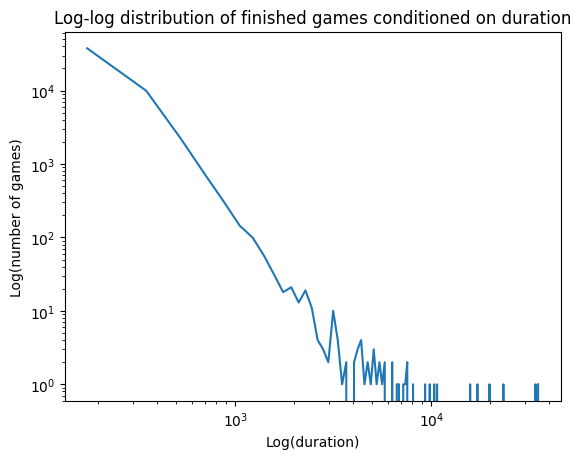

In [931]:
plt.loglog(bins_200[1][1:], bins_200[0])
plt.xlabel("Log(duration)")
plt.ylabel("Log(number of games)")
plt.title("Log-log distribution of finished games conditioned on duration")
plt.show()

In [932]:
short_walks = finished_df[finished_df['duration'] <= 3]
print(short_walks.shape)
print(short_walks['path_length'].unique())

short_walks.head()

(107, 7)
[2 3 1]


,hashIP,timestamp,duration,path,difficulty_rating,path_length,num_backward
731,321e4b101c5b58ff,2008-08-18 23:36:00,3,"[Archaeology, Anthropology]",1.0,2,0
1382,1d7a86e8252ac89d,2012-08-12 20:27:42,2,"[Batman, Superman]",NaN,2,0
1383,0dc49fcd7b52ef51,2012-09-18 21:40:26,3,"[Batman, Superman]",NaN,2,0
1384,7d5624e35c9523ef,2012-09-26 17:56:46,3,"[Batman, Superman]",NaN,2,0
1385,36691f800d571743,2012-11-13 20:15:07,2,"[Batman, Superman]",NaN,2,0


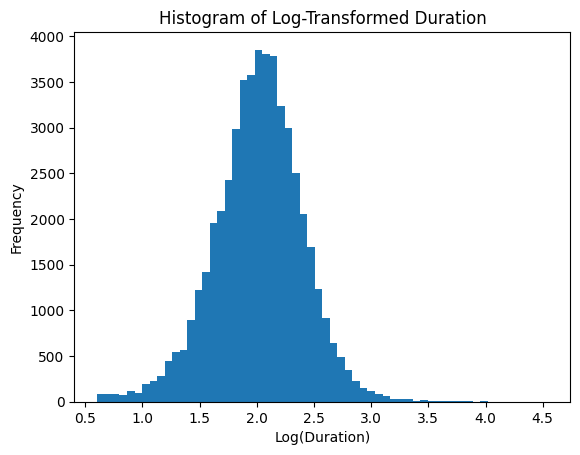

Shapiro-Wilk Test for Normality on Sampled Data:
Statistic: 0.9943970674107385, p-value: 0.06380634974613274


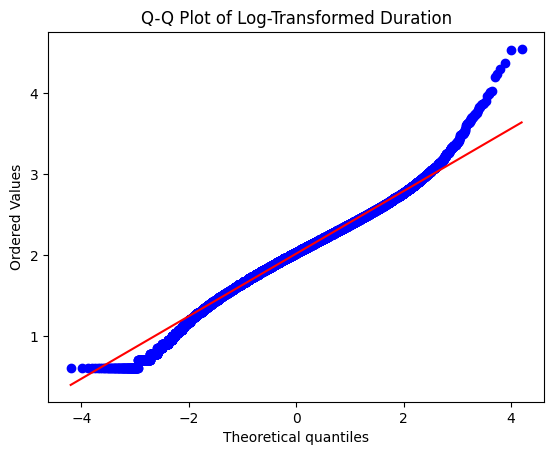

In [933]:
# Log transformation and keep only games with time > 3
log_duration = np.log10(finished_df[finished_df['duration'] > 3]['duration'])

# Histogram of log-transformed data
plt.hist(log_duration, bins=60)
plt.title("Histogram of Log-Transformed Duration")
plt.xlabel("Log(Duration)")
plt.ylabel("Frequency")
plt.show()

# Normality test (Shapiro-Wilk test)
NUM_OF_SAMPLES = 500
# Sample `NUM_OF_SAMPLES` points from the log-transformed duration data
sampled_log_duration = log_duration.sample(n=NUM_OF_SAMPLES, random_state=1)

# Perform the Shapiro-Wilk test on the sample
shapiro_test_sampled = stats.shapiro(sampled_log_duration)
print("Shapiro-Wilk Test for Normality on Sampled Data:")
print(f"Statistic: {shapiro_test_sampled.statistic}, p-value: {shapiro_test_sampled.pvalue}")

# Q-Q plot
plt.figure()
stats.probplot(log_duration, dist="norm", plot=plt)
plt.title("Q-Q Plot of Log-Transformed Duration")
plt.show()

The distribution is not exactly log normal but it is approximately

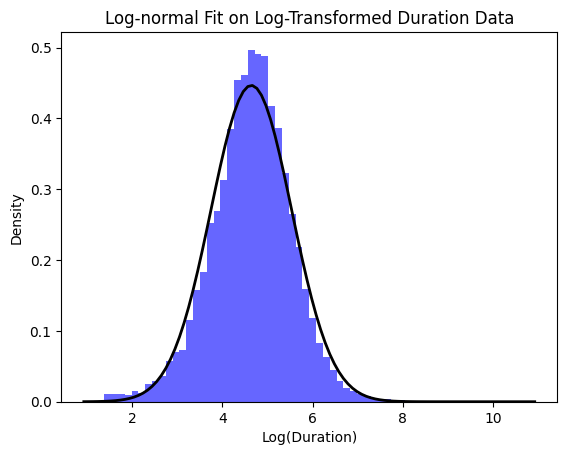

In [934]:
# Keep only games which have a duration > 3
cleaned_duration = finished_df['duration'][finished_df['duration'] > 3]

# Take the logarithm of the cleaned duration data
log_cleaned_duration = np.log(cleaned_duration)

# Fit a normal distribution to the log-transformed data
mu, sigma = stats.norm.fit(log_cleaned_duration)

# Plot the histogram of the log-transformed cleaned data
plt.hist(log_cleaned_duration, bins=60, density=True, alpha=0.6, color='b')

# Plot the PDF of the fitted log-normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Log-normal Fit on Log-Transformed Duration Data")
plt.xlabel("Log(Duration)")
plt.ylabel("Density")
plt.show()

### Difficulty ratings

It is important to keep in mind that the given difficulty ratings are given by user who successfully finished the mission, and are not an objective difficulty measure.

In [935]:
finished_df.difficulty_rating.describe()

count    28501.000000
mean         2.269780
std          1.110439
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: difficulty_rating, dtype: float64

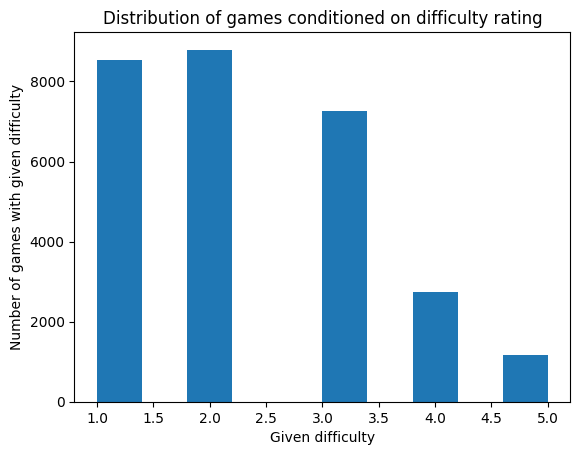

In [936]:
plt.hist(finished_df.difficulty_rating)
plt.xlabel("Given difficulty")
plt.ylabel("Number of games with given difficulty")
plt.title("Distribution of games conditioned on difficulty rating")
plt.show()

In [937]:
finished_df.difficulty_rating.value_counts().sort_index()

difficulty_rating
1.0    8542
2.0    8792
3.0    7261
4.0    2748
5.0    1158
Name: count, dtype: int64

In [938]:
print("Percentage of missing difficulty ratings: ", 100 * finished_df.difficulty_rating.isna().sum() / finished_df.difficulty_rating.shape, "%")

Percentage of missing difficulty ratings:  [44.46198215] %


We can see that in almost 45% of the cases, the user did not give a difficulty rating for the mission. Higher difficulty ratings are more rare.

### Correlations between path lenghts, duration, backward clicks and difficulty rating

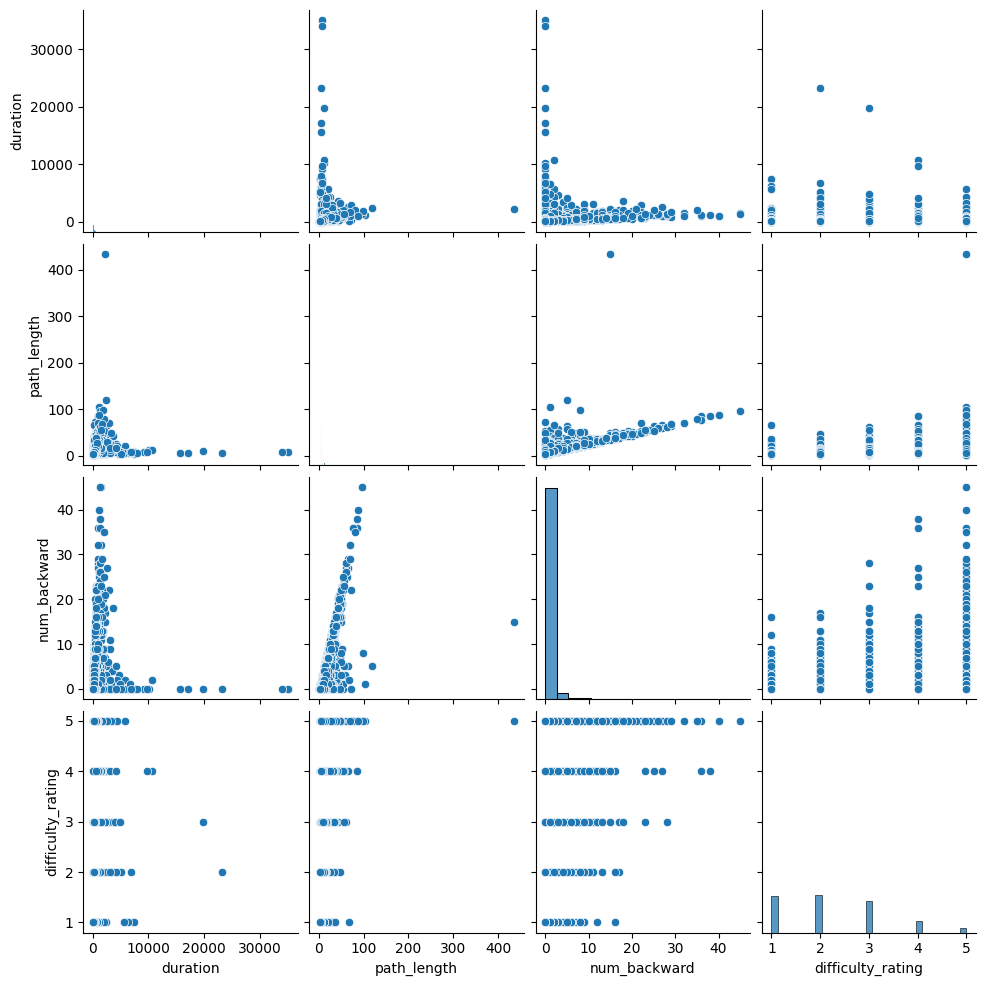

In [939]:
sns.pairplot(finished_df[['duration', 'path_length', 'num_backward', 'difficulty_rating']])
plt.show()

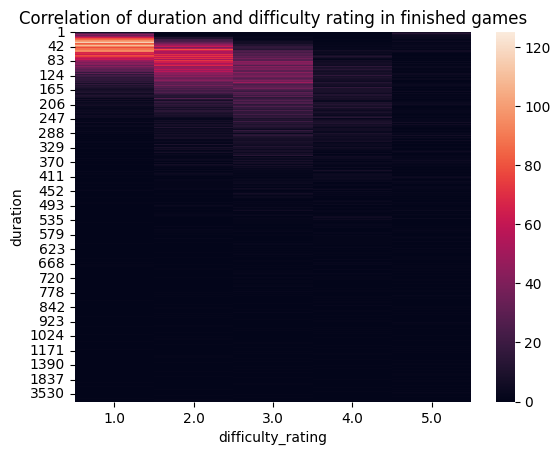

In [940]:
sns.heatmap(pd.crosstab(finished_df.duration, finished_df.difficulty_rating))
plt.title("Correlation of duration and difficulty rating in finished games")
plt.show()

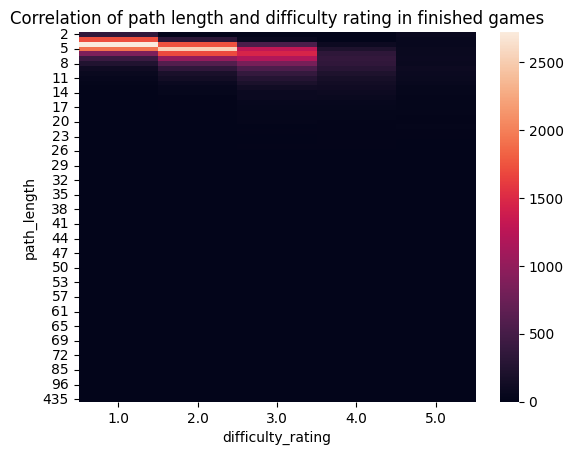

In [941]:
sns.heatmap(pd.crosstab(finished_df.path_length, finished_df.difficulty_rating))
plt.title("Correlation of path length and difficulty rating in finished games")
plt.show()

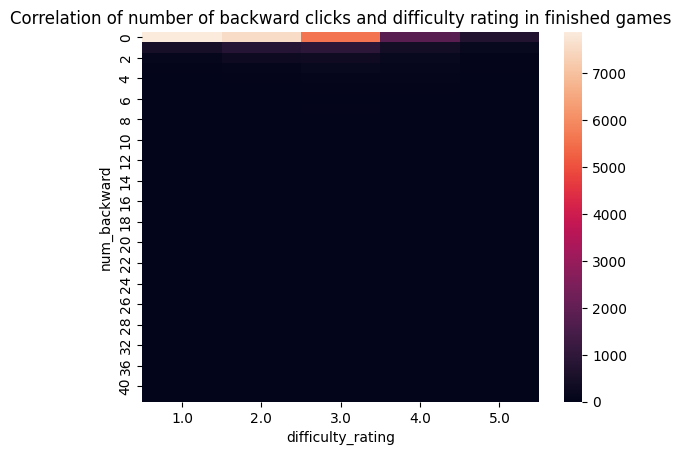

In [942]:
sns.heatmap(pd.crosstab(finished_df.num_backward, finished_df.difficulty_rating))
plt.title("Correlation of number of backward clicks and difficulty rating in finished games")
plt.show()

Ignoring the outliers, we can see a positive correlation between the difficulty rating and the duration and the path_length.

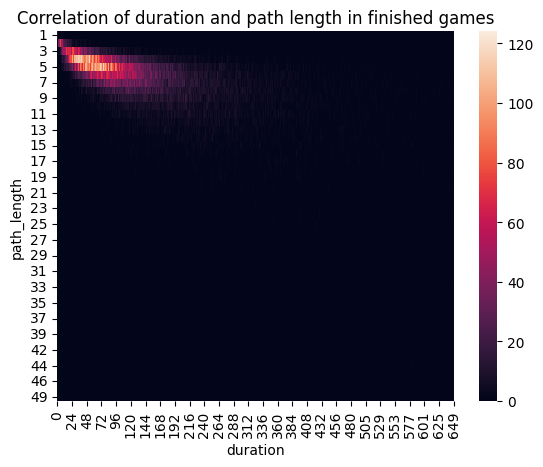

In [943]:
finished_df_copy = finished_df[(finished_df.path_length < 50) & (finished_df.duration < 650)]
sns.heatmap(pd.crosstab(finished_df_copy.path_length, finished_df_copy.duration))
plt.title("Correlation of duration and path length in finished games")
plt.show()

In [944]:
finished_df[['duration', 'path_length', 'difficulty_rating', 'num_backward']].corr(method = 'pearson')

,duration,path_length,difficulty_rating,num_backward
duration,1.000000,0.279051,0.253637,0.199282
path_length,0.279051,1.000000,0.403749,0.718316
difficulty_rating,0.253637,0.403749,1.000000,0.233722
num_backward,0.199282,0.718316,0.233722,1.000000


## Analysing unfinished paths

In [945]:
unfinished_df.head()

,hashIP,timestamp,duration,path,target_article,type_end,path_length,num_backward
0,2426091a53125110,2011-02-07 05:02:15,1804,[Obi-Wan_Kenobi],Microsoft,timeout,1,0
1,26141fd878806294,2011-02-07 05:14:11,1805,[Julius_Caesar],Caracas,timeout,1,0
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,3,0
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,[Paraguay],Mount_St._Helens,restart,1,0
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,2,0


### Path length

In [946]:
unfinished_df.path_length.describe()

count    24875.000000
mean         5.197789
std          5.772234
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        235.000000
Name: path_length, dtype: float64

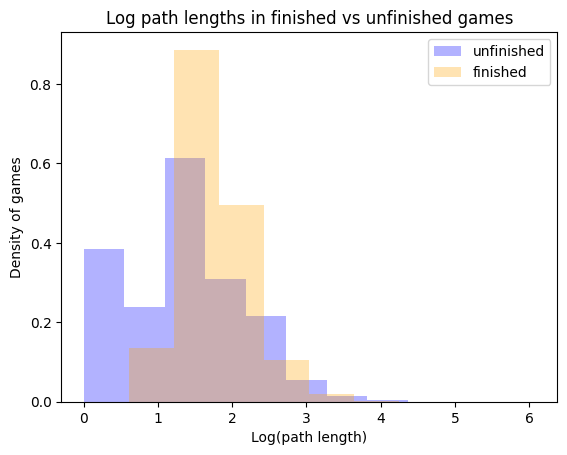

In [947]:
plt.hist(unfinished_df.path_length.apply(lambda a: np.log(a)), color = 'blue', label = 'unfinished',  alpha = 0.3, density = True)
plt.hist(finished_df.path_length.apply(lambda a: np.log(a)), color = 'orange', label = 'finished',  alpha = 0.3, density = True)
plt.legend()
plt.xlabel("Log(path length)")
plt.ylabel("Density of games")
plt.title("Log path lengths in finished vs unfinished games")
plt.show()

While the median in finished lengths for the path length was 6, here it is 4, which suggests unfinished paths are shorter.

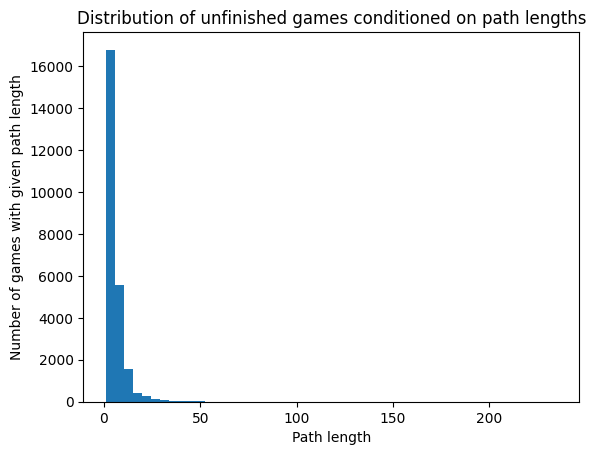

In [948]:
plt.hist(unfinished_df.path_length, bins = 50)
plt.xlabel("Path length")
plt.ylabel("Number of games with given path length")
plt.title("Distribution of unfinished games conditioned on path lengths")
plt.show()

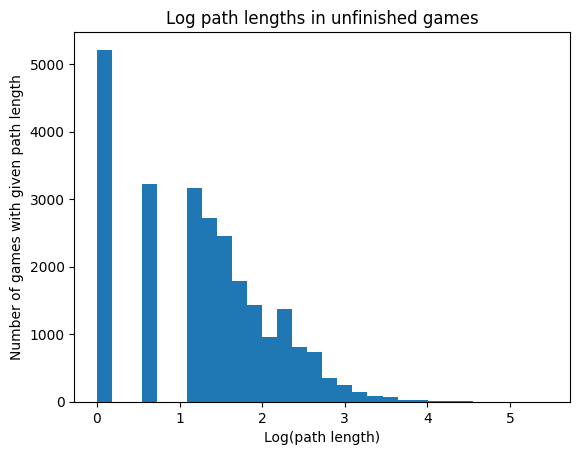

In [949]:
plt.hist(unfinished_df.path_length.apply(np.log), bins = 30)
plt.xlabel("Log(path length)")
plt.ylabel("Number of games with given path length")
plt.title("Log path lengths in unfinished games")
plt.show()

The path lengths are again coming from a skewed distribution.

### Backward option

In [950]:
unfinished_df.num_backward.describe()

count    24875.000000
mean         0.518874
std          1.821074
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         82.000000
Name: num_backward, dtype: float64

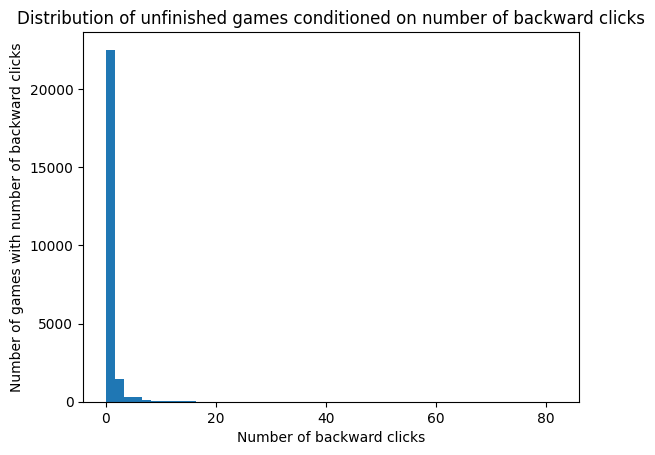

In [951]:
plt.hist(unfinished_df.num_backward, bins = 50)
plt.xlabel("Number of backward clicks")
plt.ylabel("Number of games with number of backward clicks")
plt.title("Distribution of unfinished games conditioned on number of backward clicks")
plt.show()

In [952]:
print("The backward option was not used at all in ", 100*unfinished_df.num_backward.value_counts().sort_index().iloc[0] / unfinished_df.shape[0] , " % of missions")

The backward option was not used at all in  79.09145728643216  % of missions


The backward option was used only 3% more than in finished paths.

### Type of end

In [953]:
unfinished_df.type_end.value_counts().sort_index()

type_end
restart    15552
timeout     9323
Name: count, dtype: int64

In [954]:
print("The game ends because of a restart in ", 100* unfinished_df[unfinished_df.type_end == 'restart'].shape[0] / unfinished_df.shape[0] , "% of cases")

The game ends because of a restart in  62.52060301507538 % of cases


The game can end either because of a timeout, or because the player restarted the game.

### Duration

In [955]:
unfinished_df.duration.describe()

count    24875.000000
mean       835.296884
std        881.287961
min          4.000000
25%         86.000000
50%        261.000000
75%       1831.000000
max       9089.000000
Name: duration, dtype: float64

The duration in unfinished paths is significantly bigger than in finished paths, with a 75th percentile of 1831 seconds, compared to the previous of 183.

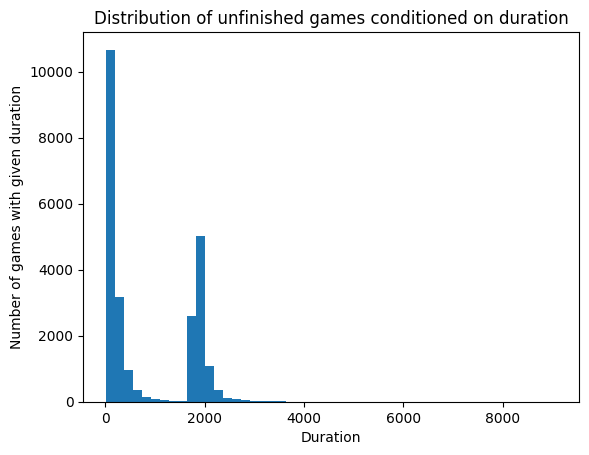

In [956]:
plt.hist(unfinished_df.duration, bins = 50)
plt.xlabel("Duration")
plt.ylabel("Number of games with given duration")
plt.title("Distribution of unfinished games conditioned on duration")
plt.show()

We notice two clusters of unfinished games depending on the duration.

However, we have to take into account that over 35% of unfinished missions ended in a timeout, so the duration in these cases is not relevant. We therefore analyse the duration again, removing the rows that ended in a timeout

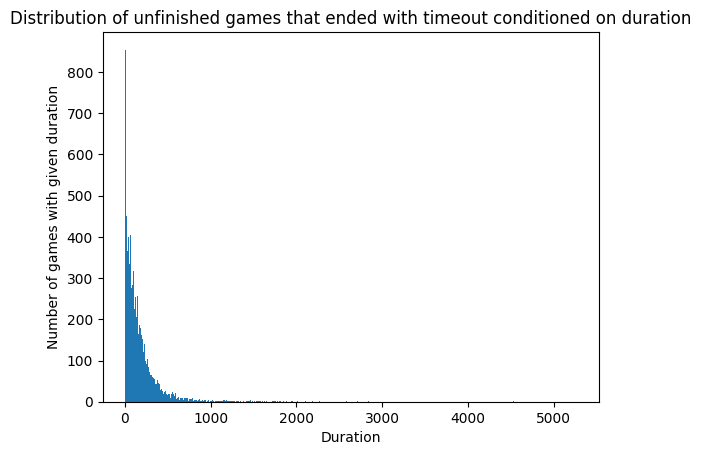

In [957]:
ended_restart = unfinished_df[unfinished_df.type_end == 'restart']
plt.hist(ended_restart.duration, bins = 1000)
plt.xlabel("Duration")
plt.ylabel("Number of games with given duration")
plt.title("Distribution of unfinished games that ended with timeout conditioned on duration")
plt.show()

In [958]:
ended_restart.duration.describe()

count    15552.000000
mean       176.575296
std        222.267962
min          4.000000
25%         48.000000
50%        114.000000
75%        224.000000
max       5263.000000
Name: duration, dtype: float64

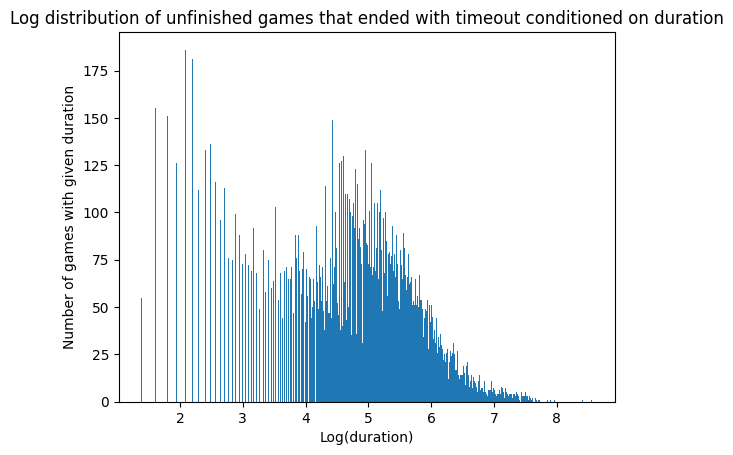

In [959]:
plt.hist(ended_restart.duration.apply(np.log), bins = 500)
plt.xlabel("Log(duration)")
plt.ylabel("Number of games with given duration")
plt.title("Log distribution of unfinished games that ended with timeout conditioned on duration")
plt.show()

The duration is shorter for the 25th percentile (it was 60 seconds before), but is bigger for the 75th percentile (was 183 before).

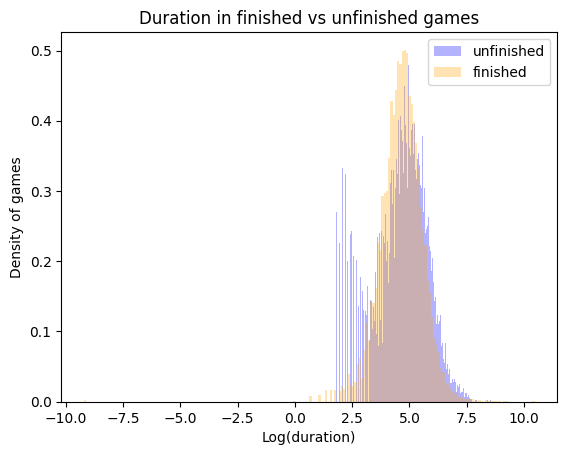

In [960]:
plt.hist(ended_restart.duration.apply(lambda a: np.log(a + 1e-4)), color = 'blue', label = 'unfinished', bins = 200, alpha = 0.3, density = True)
plt.hist(finished_df.duration.apply(lambda a: np.log(a + 1e-4)), color = 'orange', label = 'finished', bins = 200, alpha = 0.3, density = True)
plt.legend()
plt.xlabel("Log(duration)")
plt.ylabel("Density of games")
plt.title("Duration in finished vs unfinished games")
plt.show()

### Correlation between duration, path length and backward option

We will only consider rows that ended by a restart so that we make sure the duration is relevant.

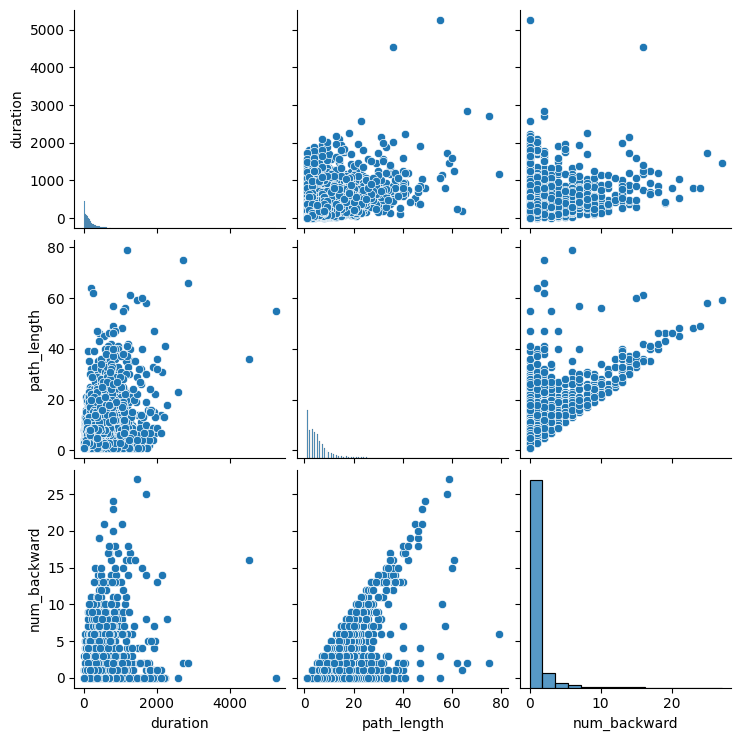

In [961]:
sns.pairplot(ended_restart[['duration', 'path_length', 'num_backward', 'type_end']])
plt.show()

In [962]:
ended_restart[['duration', 'path_length', 'num_backward']].corr(method = 'pearson')

,duration,path_length,num_backward
duration,1.000000,0.609426,0.353296
path_length,0.609426,1.000000,0.684169
num_backward,0.353296,0.684169,1.000000


We see a higher correlation than before between the path length and the duration and between the path length and the number of backward clicks.

## Analysing missions 

Our goal is to analyse the distribution of played missions depending on source and goal article, if the difficulty rating depends more on the player or on the source/goal article, how much data we have for each source/goal pair etc

In [963]:
print(unfinished_df.head())
print(finished_df.head())

             hashIP           timestamp  duration  \
0  2426091a53125110 2011-02-07 05:02:15      1804   
1  26141fd878806294 2011-02-07 05:14:11      1805   
2  2b015fb8181c48f2 2011-02-07 15:00:19      1818   
3  53a53bc244e08a6a 2011-02-07 16:06:01        49   
4  53a53bc244e08a6a 2011-02-07 17:18:25      1808   

                                       path    target_article type_end  \
0                          [Obi-Wan_Kenobi]         Microsoft  timeout   
1                           [Julius_Caesar]           Caracas  timeout   
2  [Malawi, Democracy, Alexander_the_Great]     First_Crusade  timeout   
3                                [Paraguay]  Mount_St._Helens  restart   
4                       [Paraguay, Bolivia]  Mount_St._Helens  timeout   

   path_length  num_backward  
0            1             0  
1            1             0  
2            3             0  
3            1             0  
4            2             0  
             hashIP           timestamp  duration 

In [964]:
unfinished_mod = unfinished_df.copy()
unfinished_mod['source_article'] = unfinished_mod.path.apply(lambda a: a[0])
unfinished_mod['finished'] = False
unfinished_mod = unfinished_mod.reindex(sorted(unfinished_mod.columns), axis=1)
unfinished_mod.head()
#unfinished_mod.shape[0]

,duration,finished,hashIP,num_backward,path,path_length,source_article,target_article,timestamp,type_end
0,1804,False,2426091a53125110,0,[Obi-Wan_Kenobi],1,Obi-Wan_Kenobi,Microsoft,2011-02-07 05:02:15,timeout
1,1805,False,26141fd878806294,0,[Julius_Caesar],1,Julius_Caesar,Caracas,2011-02-07 05:14:11,timeout
2,1818,False,2b015fb8181c48f2,0,"[Malawi, Democracy, Alexander_the_Great]",3,Malawi,First_Crusade,2011-02-07 15:00:19,timeout
3,49,False,53a53bc244e08a6a,0,[Paraguay],1,Paraguay,Mount_St._Helens,2011-02-07 16:06:01,restart
4,1808,False,53a53bc244e08a6a,0,"[Paraguay, Bolivia]",2,Paraguay,Mount_St._Helens,2011-02-07 17:18:25,timeout


In [965]:
finished_mod = finished_df.copy()
finished_mod['source_article'] = finished_mod.path.apply(lambda a: a[0])
finished_mod['target_article'] = finished_mod.path.apply(lambda a: a[-1])
finished_mod['finished'] = True
finished_mod = finished_mod.reindex(sorted(finished_mod.columns), axis=1)
finished_mod.head()
#finished_mod.shape[0]

,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source_article,target_article,timestamp
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40
3,NaN,37,True,64dd5cd342e3780c,0,"[14th_century, Renaissance, Ancient_Greece, Gr...",4,14th_century,Greece,2010-02-08 07:25:25
4,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08


In [966]:
# creating dataframe combining stats about finished and unfinished missions
games = pd.concat([finished_mod, unfinished_mod], ignore_index = True)
games.head()
#games.shape[0]

,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source_article,target_article,timestamp,type_end
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49,NaN
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52,NaN
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40,NaN
3,NaN,37,True,64dd5cd342e3780c,0,"[14th_century, Renaissance, Ancient_Greece, Gr...",4,14th_century,Greece,2010-02-08 07:25:25,NaN
4,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08,NaN


In [967]:
# creating dataframe that gives number of played games for each possible source/goal combination that was played at least one
count_missions = games.groupby(['source_article', 'target_article']).size() 

In [968]:
count_missions.describe()

count    42630.000000
mean         1.787309
std         17.659746
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2044.000000
dtype: float64

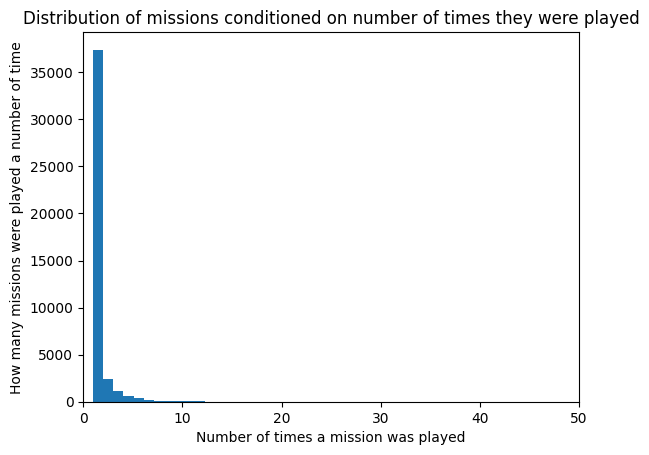

In [969]:
plt.hist(count_missions, bins = 2000)
plt.xlim(0, 50)
plt.xlabel("Number of times a mission was played")
plt.ylabel("How many missions were played a number of time")
plt.title("Distribution of missions conditioned on number of times they were played")
plt.show()

In [970]:
100*count_missions[count_missions > 10].count() / count_missions.shape[0] # % of missions played more than 10 times

0.4996481351161154

In [971]:
100 * (count_missions[(count_missions == 1) | (count_missions == 2)].count() )/ count_missions.shape[0] # % of missions played once or twice

87.70349519117993

Of all pairs of (source, goal) articles (possible missions),  87.76% have been played once or twice only. Less than 1% of missions were played more than 10 times.

### Number of played missions by player

In [972]:
player_countM = games.groupby('hashIP').size() # analysing number of missions per player
player_countM.head()

hashIP
000386124f307de8    2
0007183207b6008f    3
000a09e202e88d10    1
000a5bac5b7781ea    1
000a6e585b776c96    1
dtype: int64

In [973]:
player_countM.describe()

count    20867.000000
mean         3.651220
std         34.928749
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       4865.000000
dtype: float64

In [974]:
100*player_countM[player_countM > 5].count() / player_countM.count()

13.044520055590166

13% of players have played more than 5 games. Let's analyse if there is a correlation between the number of played games and % of finished games.

### Correlation between number of played games and winrate for players

In [975]:
player_percFinish = 100*games.groupby('hashIP')['finished'].sum() / games.groupby('hashIP').size() # percentage of finished missions for each player
player_percFinish.head()

hashIP
000386124f307de8     50.0
0007183207b6008f    100.0
000a09e202e88d10    100.0
000a5bac5b7781ea    100.0
000a6e585b776c96      0.0
dtype: float64

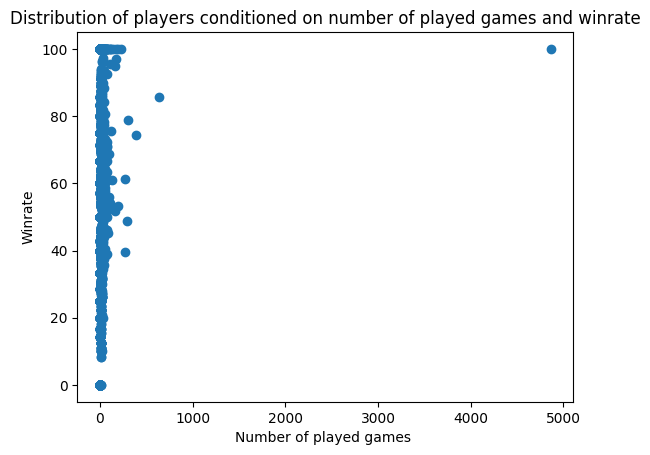

In [976]:
plt.scatter(player_countM, player_percFinish)
plt.xlabel("Number of played games ")
plt.ylabel("Winrate")
plt.title("Distribution of players conditioned on number of played games and winrate")
plt.show()

In [977]:
player_percFinish.loc[player_countM[player_countM == 4865].index]

hashIP
0d57c8c57d75e2f5    100.0
dtype: float64

There is an outlier in the number of played games: one player played 4865 games. Interestingly, the same player has successfully finished all his missions. Let's look at the previous graph by ignoring this outlier.

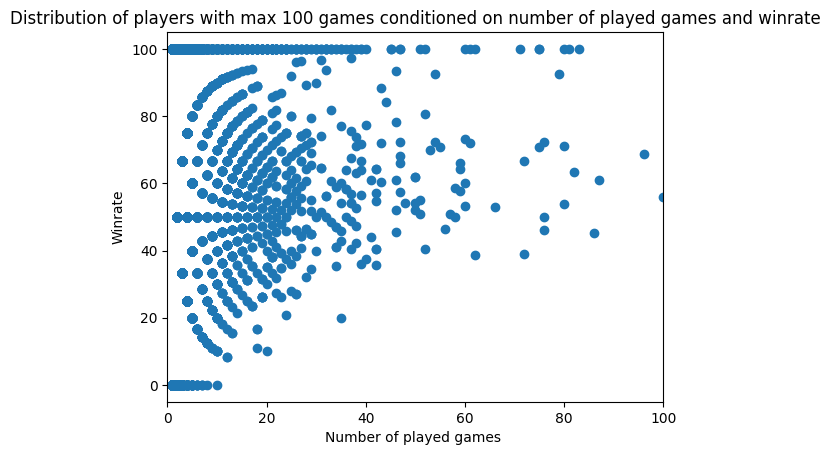

In [978]:
plt.scatter(player_countM, player_percFinish)
plt.xlim(0, 100) # looking only at players with max 100 played games
plt.xlabel("Number of played games ")
plt.ylabel("Winrate")
plt.title("Distribution of players with max 100 games conditioned on number of played games and winrate")
plt.show()

In [979]:
player_countM.corr(player_percFinish) # looking at all players

0.024809935225090295

In [980]:
player_countM[player_countM <= 100].corr(player_percFinish[player_countM <= 100]) # looking at players that played less than 100 or 100 games

0.10159801682880319

Even when looking at only players with fewer games, it is hard to see a direct correlation between the number of played games and the winrate. Let's see if the distribution of finished VS unfinished games varies a lot between players.

### Distribution of winrates of players

In [981]:
player_percFinish.describe()

count    20867.000000
mean        56.915431
std         43.972501
min          0.000000
25%          0.000000
50%         66.666667
75%        100.000000
max        100.000000
dtype: float64

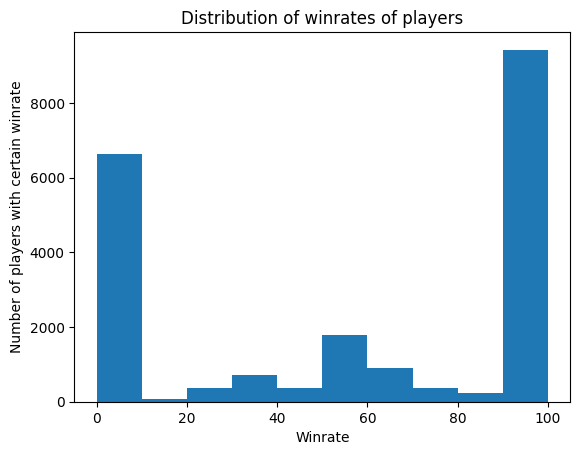

In [982]:
plt.hist(player_percFinish)
plt.xlabel("Winrate")
plt.ylabel("Number of players with certain winrate")
plt.title("Distribution of winrates of players")
plt.show()

In [983]:
print(100 * player_percFinish[player_percFinish == 0].count()/player_percFinish.count(), "% of players have a winrate of 0%, ", 100 * player_percFinish[player_percFinish == 100].count()/player_percFinish.count(), "% of players have a winrate of 100%")

31.739109598888195 % of players have a winrate of 0%,  44.960943115924664 % of players have a winrate of 100%


### Analysing given difficulty ratings for missions

Let's now see if there is a correlation between the difficulty given by players for a mission and the percentage of games of this missions where people did not succeed. First, we will check how many missions are present in both finished and unfinished paths 

In [984]:
games.head()

,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source_article,target_article,timestamp,type_end
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49,NaN
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52,NaN
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40,NaN
3,NaN,37,True,64dd5cd342e3780c,0,"[14th_century, Renaissance, Ancient_Greece, Gr...",4,14th_century,Greece,2010-02-08 07:25:25,NaN
4,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08,NaN


In [985]:
counts_per_mission = games[['source_article', 'target_article', 'finished']].drop_duplicates().groupby(['source_article', 'target_article']).count()
counts_per_mission.head()
missions_both = counts_per_mission[counts_per_mission['finished'] == 2].reset_index(level=['source_article', 'target_article'])[['source_article', 'target_article']]
missions_both.head() # dataframe containing missions that are both in finished and unfinished paths

,source_article,target_article
0,11th_century,Plum
1,12th_century,Guitar
2,13th_century,Bison
3,13th_century,Olive_oil
4,14th_century,African_slave_trade


In [986]:
100*missions_both.shape[0] / games[['source_article', 'target_article']].drop_duplicates().shape[0]

10.032840722495894

Only 9.82% of possible missions were at least won once and at least lost once by someone. For all these missions, let's collect the number of times they were won, the number of times they were lost, the number of available difficulty ratings and the average difficulty rating (if any).

In [987]:
games_both = games.merge(missions_both, on = ['source_article', 'target_article'], how='inner')
games_both = games_both.groupby(['source_article', 'target_article']).agg(no_won = ('finished', 'sum'), no_lost = ('finished', lambda a: (a == False).sum()), no_diff = ('difficulty_rating', 'count'), avg_diff = ('difficulty_rating', 'mean'))
games_both.head() # dataframe containing information about games that were won and lost at least once

no_won  no_lost  no_diff  avg_diff
source_article target_article                                         
11th_century   Plum                      1        1        1       1.0
12th_century   Guitar                    4        1        4       3.0
13th_century   Bison                     2        2        2       1.0
               Olive_oil                 1        1        0       NaN
14th_century   African_slave_trade       3        4        1       3.0

In [988]:
100*games_both.query("no_diff == 0").shape[0] / games_both.shape[0]

22.632686462473696

In [989]:
100*games.groupby(['source_article', 'target_article']).count().query("difficulty_rating == 0").shape[0] / games.groupby(['source_article', 'target_article']).count().shape[0] 

52.730471498944404

Out of all games that were at least won and lost once, only 22% have 0 difficulty ratings, which is way lower than when we took into account all played missions, where almost 53% of missions had no difficulty rating.

In [990]:
games_both.describe()

,no_won,no_lost,no_diff,avg_diff
count,4277.000000,4277.000000,4277.000000,3309.000000
mean,3.671031,2.504325,1.726444,2.607886
std,28.657162,27.379266,11.001849,1.048081
min,1.000000,1.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000
50%,2.000000,1.000000,1.000000,2.500000
75%,3.000000,2.000000,2.000000,3.000000
max,1043.000000,1004.000000,404.000000,5.000000


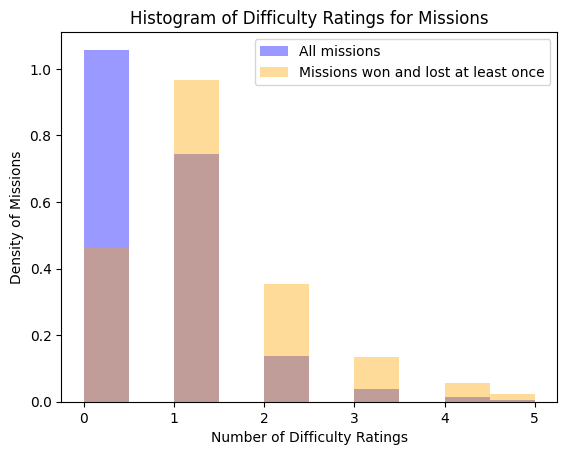

In [991]:
# distribution of count of difficulty ratings per mission in dataframe of all games
games_diff = games.groupby(['source_article', 'target_article']).count()['difficulty_rating'] 

# distribution of count of difficulty ratings per mission in dataframe of games that were at least won and lost once
games_both_diff = games_both['no_diff']

plt.hist(games_diff, range=(0, 5), alpha=0.4, color='blue', label='All missions', density = True)
plt.hist(games_both_diff, range=(0, 5), alpha=0.4, color='orange', label='Missions won and lost at least once', density = True)

plt.xlabel("Number of Difficulty Ratings")
plt.ylabel("Density of Missions")
plt.title("Histogram of Difficulty Ratings for Missions")
plt.legend()

plt.show()

We can see how when looking at games that were at least won and lost once, the distribution of the number of difficulty ratings is more diverse than in the case where we are looking at all the missions, where most of the missions had no difficulty rating.

#### Correlation between average difficulty of a mission (given by players) and winrate of that mission

We can now finally check if there is a correlation between the average difficulty rating and the number of times a game was lost for games that were lost and won at least once.

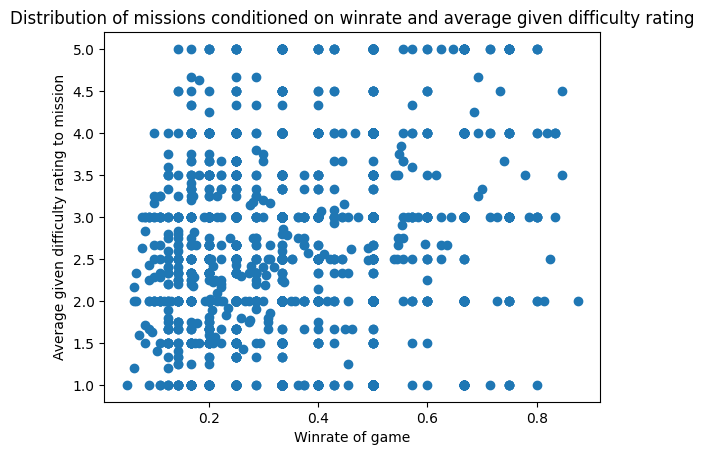

In [992]:
one_diff = games_both[games_both['no_diff'] != 0] # look at games that have at least one difficulty rating
perc_lost = one_diff.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis = 1) # calculate percentage of lost games
plt.xlabel("Winrate of game")
plt.ylabel("Average given difficulty rating to mission")
plt.title("Distribution of missions conditioned on winrate and average given difficulty rating")
plt.scatter(perc_lost, one_diff['avg_diff'])
plt.show()

In [993]:
perc_lost.corr(one_diff['avg_diff'])

0.15184043914325374

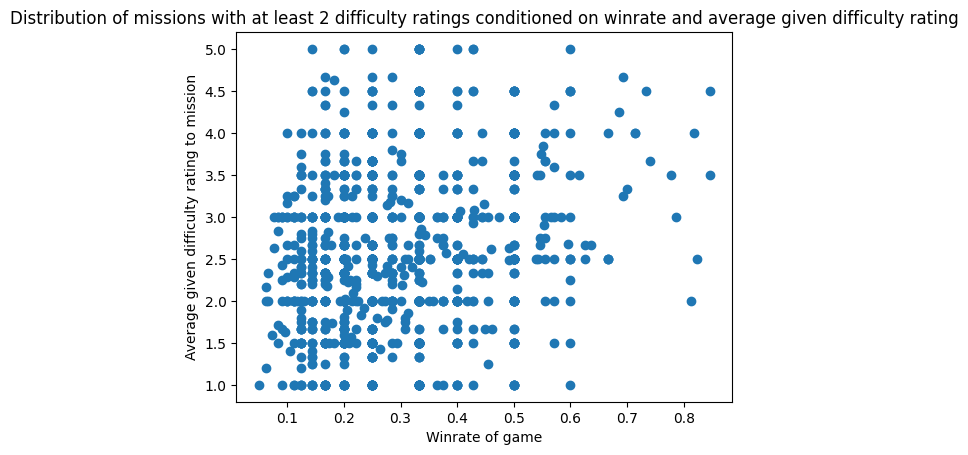

In [994]:
one_diff = games_both[games_both['no_diff'] > 1] # look at games that have at least two difficulty rating
perc_lost = one_diff.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis = 1) # calculate percentage of lost games
plt.scatter(perc_lost, one_diff['avg_diff'])
plt.xlabel("Winrate of game")
plt.ylabel("Average given difficulty rating to mission")
plt.title("Distribution of missions with at least 2 difficulty ratings conditioned on winrate and average given difficulty rating")
plt.show()

In [995]:
perc_lost.corr(one_diff['avg_diff'])

0.20341496167592044

We can see the correlation score is bigger if we take into account only the missions for which we have more difficulty ratings.

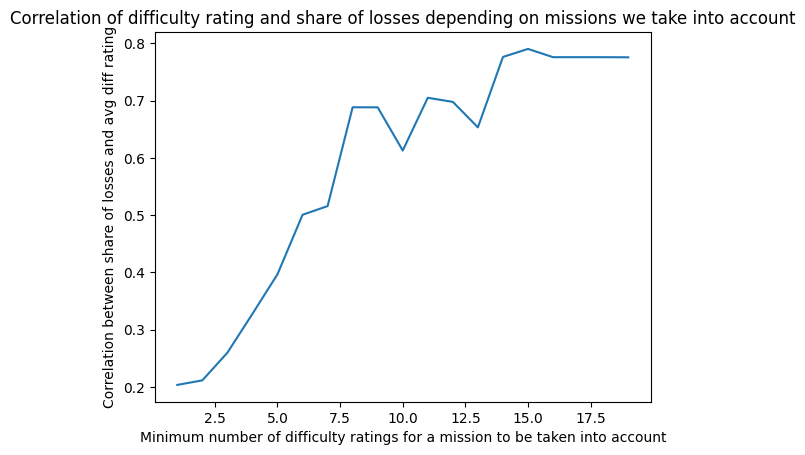

In [996]:
x = range(1, 20)
corr = []
for i in x:
    one_diff = games_both[games_both['no_diff'] > i] # look at games that have at least i difficulty rating
    perc_lost = one_diff.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis = 1) # calculate percentage of lost games
    corr.append(perc_lost.corr(one_diff['avg_diff']))
plt.plot(x, corr)
plt.xlabel("Minimum number of difficulty ratings for a mission to be taken into account")
plt.ylabel("Correlation between share of losses and avg diff rating")
plt.title("Correlation of difficulty rating and share of losses depending on missions we take into account")
plt.show()

#### Correlation between given difficulty rating and player that played

Until now, we haven't taken into account the player that plays a certain mission. We will now analyse how much does the difficulty rating depend on the player by checking if different players give different difficulty ratings even if they both lost / won the same amount of missions / the same missions. This can help us detect player bias - if some players consistently give higher or lower ratings.

In [997]:
# creating a dataframe where for each player we have number of wins, losses, number of given diff rating and avg difficulty rating
player_stat = games.groupby('hashIP').agg(no_won = ('finished', 'sum'), no_lost = ('finished', lambda a: (a == False).sum()), no_rating = ('difficulty_rating', 'count'), avg_rating = ('difficulty_rating', 'mean'))
player_stat.head()

,no_won,no_lost,no_rating,avg_rating
hashIP,,,,
000386124f307de8,1,1,1,1.0
0007183207b6008f,3,0,1,1.0
000a09e202e88d10,1,0,1,3.0
000a5bac5b7781ea,1,0,0,NaN
000a6e585b776c96,0,1,0,NaN


In [998]:
100*player_stat[player_stat['no_rating'] > 0].shape[0] / player_stat.shape[0]

45.87147170173

Only 45% of players gave at least one difficulty rating. FIrst, let's see if we can find something in common for all players that did not give any ranking. Is their distribution of % of won games very different than for players that did give ratings?

In [999]:
perc_distr_noRank = player_stat[player_stat['no_rating'] == 0].apply(lambda a: a.no_won / (a.no_won + a.no_lost), axis = 1)
perc_distr_noRank.head() # winrate for players that did not give any ranking

perc_distr_Rank = player_stat[player_stat['no_rating'] > 0].apply(lambda a: a.no_won / (a.no_won + a.no_lost), axis = 1)
perc_distr_Rank.head() # winrate for players that gave at least one rating

hashIP
000386124f307de8    0.5
0007183207b6008f    1.0
000a09e202e88d10    1.0
000bc9fe5640ed31    1.0
000d397013f09039    1.0
dtype: float64

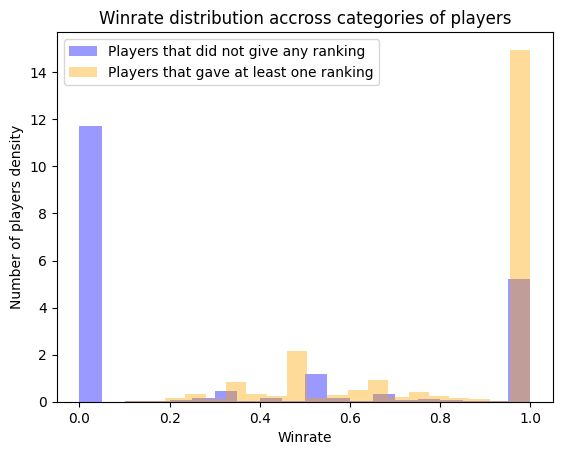

In [1000]:
# distribution of winrate accross players
plt.hist(perc_distr_noRank, alpha=0.4, color='blue', bins = 20, label='Players that did not give any ranking', density = True)
plt.hist(perc_distr_Rank, alpha=0.4, color='orange', bins = 20, label='Players that gave at least one ranking', density = True)

plt.xlabel("Winrate")
plt.ylabel("Number of players density")
plt.title("Winrate distribution accross categories of players")
plt.legend()

plt.show()

In [1001]:
perc_distr_Rank.describe()

count    9572.000000
mean        0.844325
std         0.242775
min         0.100000
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64

In [1002]:
perc_distr_noRank[perc_distr_noRank == 0].size / perc_distr_noRank.size # how many have winrate 0 that did not give rating

0.586365648517043

In [1003]:
perc_distr_noRank[perc_distr_noRank == 1].size / perc_distr_noRank.size # how many have winrate 1 that did not give rating

0.2606463036741921

In [1004]:
perc_distr_Rank[perc_distr_Rank == 1].size / perc_distr_Rank.size # how many have winrate 1 that did give rating

0.6725867112411199

For players that did not give any rating, 58% of them failed all their missions, 26% succeeded all missions, and the rest have a winrate that is between 0 or 1. Players that gave at least one ranking have a winrate of 1 in 67% of cases, but also have a winrate between 0 and 1 more often than players that did not give any ratings. From all players that gave at least one ranking, no one had a winrate of 0.

We will now focus on players that gave ratings and see if the given average rating depends on the winrate (and so, is very similar for players with same winrates) or if it is player dependent (some players tend to give higher / lower ratings).

In [1005]:
player_with_rating = player_stat[player_stat['no_rating'] > 0] # information about players that gave at least one rating
player_with_rating.head()

,no_won,no_lost,no_rating,avg_rating
hashIP,,,,
000386124f307de8,1,1,1,1.0
0007183207b6008f,3,0,1,1.0
000a09e202e88d10,1,0,1,3.0
000bc9fe5640ed31,2,0,2,1.0
000d397013f09039,2,0,2,2.0


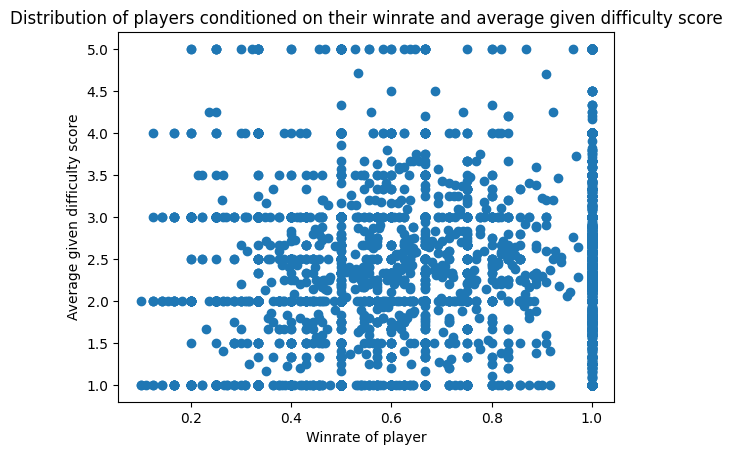

In [1006]:
plt.scatter(perc_distr_Rank, player_with_rating['avg_rating']) # showing relationship between winrate and average rating
plt.xlabel("Winrate of player")
plt.ylabel("Average given difficulty score")
plt.title("Distribution of players conditioned on their winrate and average given difficulty score")
plt.show()

In [1007]:
player_with_rating.loc[:, 'winrate'] = player_with_rating['no_won'] / (player_with_rating['no_won'] + player_with_rating['no_lost'])

C:\Users\bgabe\AppData\Local\Temp\ipykernel_16052\1141648315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_with_rating.loc[:, 'winrate'] = player_with_rating['no_won'] / (player_with_rating['no_won'] + player_with_rating['no_lost'])


C:\Users\bgabe\AppData\Local\Temp\ipykernel_16052\536374785.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_devs = player_with_bins.groupby('winrate_bin')['avg_rating'].std()
C:\Users\bgabe\AppData\Local\Temp\ipykernel_16052\536374785.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = player_with_bins.groupby('winrate_bin')['avg_rating'].count()


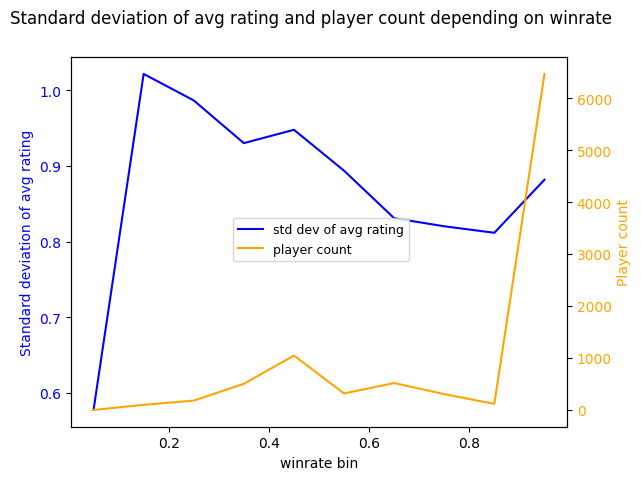

In [1008]:
x = np.linspace(0, 1, 11)
player_with_bins = player_with_rating.copy()
player_with_bins['winrate_bin'] = pd.cut(player_with_rating['winrate'], bins=x)

std_devs = player_with_bins.groupby('winrate_bin')['avg_rating'].std()
counts = player_with_bins.groupby('winrate_bin')['avg_rating'].count()

x = std_devs.index.categories.mid
y_std = std_devs.values
y_count = counts.values

fig, axes = plt.subplots()

axes.plot(x, y_std, color='blue', label='std dev of avg rating')
axes.set_xlabel("winrate bin")
axes.set_ylabel("Standard deviation of avg rating", color='blue')
axes.tick_params(axis='y', labelcolor='blue')

axes2 = axes.twinx()
axes2.plot(x, y_count, color='orange', label='player count')
axes2.set_ylabel("Player count", color='orange')
axes2.tick_params(axis='y', labelcolor='orange')

fig.suptitle("Standard deviation of avg rating and player count depending on winrate")
fig.legend(loc="center", fontsize = 9)
plt.show()


We can see standard deviation of average rating stays high even when we compare players of same winrate, which means that the average rating depends a lot on the characteristics of a player, and not only on their winrate. F.e. a player may always give higher/lower ratings.

In [1009]:
player_with_rating[player_with_rating['winrate'] == 1].head()

,no_won,no_lost,no_rating,avg_rating,winrate
hashIP,,,,,
0007183207b6008f,3,0,1,1.0,1.0
000a09e202e88d10,1,0,1,3.0,1.0
000bc9fe5640ed31,2,0,2,1.0,1.0
000d397013f09039,2,0,2,2.0,1.0
0013e00d2529e52c,7,0,5,2.2,1.0


In [1010]:
perc_distr_Rank.corr( player_with_rating['avg_rating']) # correlation factor between winrate and difficulty rating

-0.01298440657258057

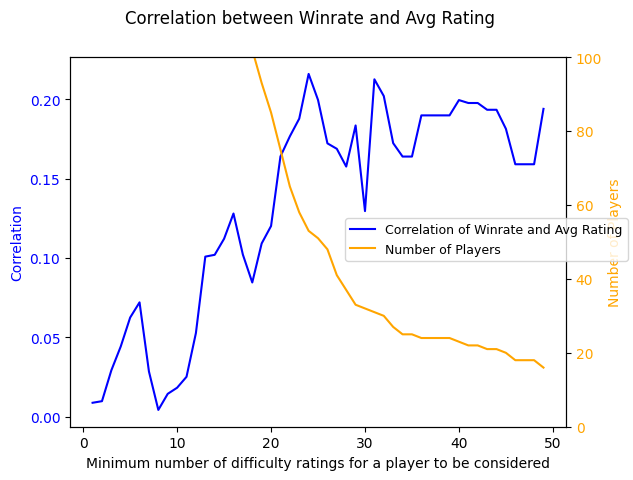

In [1011]:
x = range(1, 50)
corr = []
num_players = []

for i in x:
    one_rat = player_with_rating[player_with_rating['no_rating'] > i] # players with at least i given rankings
    perc_lost = one_rat.apply(lambda a: a.no_lost / (a.no_won + a.no_lost), axis=1) # winrate for them
    corr.append(perc_lost.corr(one_rat['avg_rating'])) # append correlation
    num_players.append(len(one_rat)) # append number of players

fig, axes = plt.subplots()

axes.plot(x, corr, color='blue', label='Correlation of Winrate and Avg Rating')
axes.set_xlabel("Minimum number of difficulty ratings for a player to be considered")
axes.set_ylabel("Correlation", color='blue')
axes.tick_params(axis='y', labelcolor='blue')

axes2 = axes.twinx()
axes2.plot(x, num_players, color='orange', label='Number of Players')
axes2.set_ylabel("Number of Players", color='orange')
axes2.set_ylim(0, 100)
axes2.tick_params(axis='y', labelcolor='orange')

fig.suptitle("Correlation between Winrate and Avg Rating")
fig.legend(loc="center right", fontsize = 9)
plt.show()


The correlation between the winrate and average rating a player gave is not very significant as it stays under 0.25. We can see that the correlation between the winrate and avg rating of a player increases when we take into account only players that gave more ratings, but this reduces the number of players from which we can take the data. 

### Change of shortest path in first 3 clicks

We noticed that in some unfinished games, the target article name does not exist in the list of all articles, f.e. "Podcast" or "Long_peper" (only "Podcasting" and "Long_pepper" articles exist), so we remove those games.

In [1012]:
games = games[games['target_article'].isin(articles_df['article_name'])]

In [1013]:
games_first3 = games[['source_article', 'target_article', 'path']]
games_first3 = games_first3[games_first3['path'].apply(len) > 4]

In [1014]:
games_first3['first_click'] = games_first3.apply(lambda a: a.path[1], axis = 1)
games_first3['second_click'] = games_first3.apply(lambda a: a.path[2], axis = 1)
games_first3['third_click'] = games_first3.apply(lambda a: a.path[3], axis = 1)

In [1015]:
games_first3.head()

,source_article,target_article,path,first_click,second_click,third_click
0,14th_century,African_slave_trade,"[14th_century, 15th_century, 16th_century, Pac...",15th_century,16th_century,Pacific_Ocean
1,14th_century,African_slave_trade,"[14th_century, Europe, Africa, Atlantic_slave_...",Europe,Africa,Atlantic_slave_trade
2,14th_century,African_slave_trade,"[14th_century, Niger, Nigeria, British_Empire,...",Niger,Nigeria,British_Empire
4,14th_century,John_F._Kennedy,"[14th_century, Italy, Roman_Catholic_Church, H...",Italy,Roman_Catholic_Church,HIV
5,14th_century,John_F._Kennedy,"[14th_century, Europe, North_America, United_S...",Europe,North_America,United_States


In [1016]:
def get_sp(row, i): # get length of shortest path between article number i in game path and target of game
    article_name = row.path[i]
    while(article_name == "<"):
        i = i-1
        article_name = row.path[i]
    source_article = article_name
    target_article = row['target_article']
    return distance_df.loc[source_article, target_article]

games_first3['initial_sp'] = games_first3.apply(lambda a: get_sp(a, 0), axis=1)
games_first3['first_sp'] = games_first3.apply(lambda a: get_sp(a, 1), axis=1)
games_first3['second_sp'] = games_first3.apply(lambda a: get_sp(a, 2), axis=1)
games_first3['third_sp'] = games_first3.apply(lambda a: get_sp(a, 3), axis=1)

In [1017]:
games_first3.head()

,source_article,target_article,path,first_click,second_click,third_click,initial_sp,first_sp,second_sp,third_sp
0,14th_century,African_slave_trade,"[14th_century, 15th_century, 16th_century, Pac...",15th_century,16th_century,Pacific_Ocean,3.0,3.0,3.0,3.0
1,14th_century,African_slave_trade,"[14th_century, Europe, Africa, Atlantic_slave_...",Europe,Africa,Atlantic_slave_trade,3.0,3.0,2.0,1.0
2,14th_century,African_slave_trade,"[14th_century, Niger, Nigeria, British_Empire,...",Niger,Nigeria,British_Empire,3.0,3.0,2.0,3.0
4,14th_century,John_F._Kennedy,"[14th_century, Italy, Roman_Catholic_Church, H...",Italy,Roman_Catholic_Church,HIV,3.0,2.0,2.0,2.0
5,14th_century,John_F._Kennedy,"[14th_century, Europe, North_America, United_S...",Europe,North_America,United_States,3.0,2.0,2.0,1.0


In [1018]:
print(f"We observe {games_first3.shape[0]} games")

We observe 49065 games


In [1019]:
print(f"In {100*games_first3[(games_first3['initial_sp'] == games_first3['first_sp']) & (games_first3['initial_sp'] == games_first3['second_sp']) & (games_first3['initial_sp'] == games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path does not change in the first 3 clicks.")

In 13.111179048201366% games the shortest path does not change in the first 3 clicks.


In [1020]:
print(f"In {100*games_first3[(games_first3['initial_sp'] > games_first3['first_sp']) & (games_first3['first_sp'] > games_first3['second_sp']) & (games_first3['second_sp'] > games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path diminishes for each of the first 3 clicks.")

In 2.6067461530622644% games the shortest path diminishes for each of the first 3 clicks.


In [1021]:
print(f"In {100*games_first3[(games_first3['initial_sp'] < games_first3['first_sp']) & (games_first3['first_sp'] < games_first3['second_sp']) & (games_first3['second_sp'] < games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path becomes larger for each of the first 3 clicks.")

In 0.0020381127076327323% games the shortest path becomes larger for each of the first 3 clicks.


In [1022]:
print(f"In {100*games_first3[(games_first3['initial_sp'] == games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path is the same at the beginning and after the third click.")

In 26.554570467746867% games the shortest path is the same at the beginning and after the third click.


In [1023]:
print(f"In {100*games_first3[(games_first3['initial_sp'] < games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path is larger after the third click than at the beginning.")

In 3.2161418526444514% games the shortest path is larger after the third click than at the beginning.


In [1024]:
print(f"In {100*games_first3[(games_first3['initial_sp'] > games_first3['third_sp'])].shape[0]/games_first3.shape[0]}% games the shortest path is smaller after the third click than at the beginning.")

In 70.1926016508713% games the shortest path is smaller after the third click than at the beginning.
